## 1. Imports

In [1]:
import bisect
import collections
import datetime
import functools
import gc
import itertools
import logging
import math
import operator
import os
import pickle
import random
import sys
import time
import warnings

import livelossplot
import matplotlib
import optuna
import re
import sklearn
import torch
import tqdm

warnings.filterwarnings('ignore')

import numpy             as np
import pandas            as pd
import scipy             as sp
import tensorflow        as tf
import tensorflow_addons as tfa
import torch.nn          as nn

In [2]:
from collections                 import defaultdict
from functools                   import reduce
from matplotlib                  import font_manager
from matplotlib                  import pyplot as plt
from scipy.signal                import savgol_filter
from scipy.spatial.distance      import cdist
from sklearn                     import linear_model
from tensorflow                  import keras
from torch.autograd              import Variable
from tqdm.keras                  import TqdmCallback

from sklearn.cross_decomposition import PLSRegression
from sklearn.datasets            import make_regression
from sklearn.decomposition       import PCA
from sklearn.ensemble            import RandomForestRegressor
from sklearn.metrics             import accuracy_score
from sklearn.metrics             import mean_absolute_error
from sklearn.metrics             import mean_squared_error
from sklearn.metrics             import r2_score
from sklearn.model_selection     import cross_val_predict
from sklearn.model_selection     import train_test_split
from sklearn.preprocessing       import MinMaxScaler
from sklearn.preprocessing       import Normalizer
from sklearn.preprocessing       import StandardScaler
from sklearn.utils               import shuffle

from keras.activations           import *
from keras.callbacks             import *
from keras.initializers          import *
from keras.layers                import *
from keras.models                import *
from keras.optimizers            import *
from keras.regularizers          import *

from optuna.samplers             import *
from optuna.pruners              import *

In [3]:
def print_version():
    
    print('     livelossplot: version', livelossplot.__version__)
    print('       matplotlib: version',   matplotlib.__version__)
    print('           optuna: version',       optuna.__version__)
    print('               re: version',           re.__version__)
    print('          sklearn: version',      sklearn.__version__)
    print('            torch: version',        torch.__version__)
    print('             tqdm: version',         tqdm.__version__, '\n')
    
    print('            numpy: version',           np.__version__)
    print('           pandas: version',           pd.__version__)
    print('            scipy: version',           sp.__version__)
    print('       tensorflow: version',           tf.__version__)
    print('tensorflow_addons: version',          tfa.__version__, '\n')

In [4]:
def init():
    
    random.seed(0)
    np.random.seed(0)
    tf.random.set_seed(0)
    torch.manual_seed(0)
    os.environ['PYTHONHASHSEED'] = '0'
    
    plt.style.use('ggplot')
    np.set_printoptions(precision=4, threshold=sys.maxsize, suppress=True, sign=' ', floatmode='fixed')

WL = pd.read_excel('data/wavelength.xlsx', 1, header=None).iloc[:,3].to_numpy().astype(np.float64)
wl_range = np.concatenate([range(0, 1899, 100), [-1]])

## 2. Help Functions

In [5]:
def curr_date(): return datetime.datetime.now().strftime('%Y%m%d')

def curr_time(): return datetime.datetime.now().strftime('%Y/%m/%d %H:%M')

def mean_centering(X, axis=None):
    
    '''
    return the mean-centering of the 2D array X
    axis == None: element-wise mean-centering
    axis == 0   :  column-wise mean-centering
    axis == 1   :     row-wise mean-centering
    '''
    
    if axis not in [None, 0, 1]: raise ValueError('Unexpected axis value.')
    
    X_mean = np.mean(X, axis=axis)
    
    if axis != None: X_mean = np.expand_dims(X_mean, axis=axis)
    
    return X - X_mean

def normalization(X, axis=None):
    
    '''
    return the normalization of the 2D array X such that each element is in [0, 1]
    axis == None: element-wise normalization
    axis == 0   :  column-wise normalization
    axis == 1   :     row-wise normalization
    '''
    
    if axis not in [None, 0, 1]: raise ValueError('Unexpected axis value.')
    
    X_min = np.min(X, axis=axis)
    X_max = np.max(X, axis=axis)
    
    if axis != None:
        
        X_min = np.expand_dims(X_min, axis=axis)
        X_max = np.expand_dims(X_max, axis=axis)
    
    return (X - X_min) / (X_max - X_min)

def standardization(X, axis=None):
    
    '''
    return the standardization of the 2D array X such that each element is subtracted the mean and divided by the standard deviation
    axis == None: element-wise standardization
    axis == 0   :  column-wise standardization
    axis == 1   :     row-wise standardization
    X_snv == standardization(X, axis=1) == StandardScaler().fit_transform(X.T).T
    '''
    
    if axis not in [None, 0, 1]: raise ValueError('Unexpected axis value.')
    
    X_mean = np.mean(X, axis=axis)
    X_std  = np.std (X, axis=axis)
    
    if axis != None:
        
        X_mean = np.expand_dims(X_mean, axis=axis)
        X_std  = np.expand_dims(X_std , axis=axis)
    
    return (X - X_mean) / X_std

def MSC(X, mean_center=True, reference=None):
    
    '''
    Multiplicative Scatter Correction
    mean_center: mean-centering each row of the 2D array X if true
    reference: optional reference spectrum
    '''
    
    if mean_center: X = np.array([row - row.mean() for row in X])
    
    X_msc = np.empty(X.shape)
    X_ref = np.mean(X, axis=0) if reference == None else reference
    
    for i in range(X.shape[0]):
        
        a, b = np.polyfit(X_ref, X[i], 1)
        X_msc[i] = (X[i] - b) / a
    
    return X_msc

In [6]:
def custom_train_test_split(X, Y, method, test_size, random_state=None):
    
    if method == 'random': return train_test_split([i for i in range(X.shape[0])], test_size=test_size, random_state=random_state)
    
    if method == 'ks': distance = cdist(X, X)
    
    if method == 'spxy':
        
        Y = np.expand_dims(Y, axis=-1)
        
        distance_x  = cdist(X, X)
        distance_y  = cdist(Y, Y)
        
        distance_x /= distance_x.max()
        distance_y /= distance_y.max()
        
        distance    = distance_x + distance_y
    
    if 0 < test_size < 1: test_size = int(X.shape[0] * test_size)
    
    return max_min_distance_split(distance, X.shape[0] - test_size)

def max_min_distance_split(distance, train_size):
    
    i_train = []
    i_test  = [i for i in range(distance.shape[0])]
    
    first_two_points = np.unravel_index(np.argmax(distance), distance.shape)
    
    i_train.append(first_two_points[0])
    i_train.append(first_two_points[1])
    
    i_test .remove(first_two_points[0])
    i_test .remove(first_two_points[1])
    
    for _ in range(train_size - 2):
        max_min_dist_idx = np.argmax(np.min(distance[i_train,:], axis=0))
        i_train.append(max_min_dist_idx)
        i_test .remove(max_min_dist_idx)
    
    return i_train, i_test

In [7]:
def plot_prediction(Y_train, Y_train_pred, Y_test, Y_test_pred, title='', plot=True):
    
    mae_train  = mean_absolute_error(Y_train, Y_train_pred)
    mae_test   = mean_absolute_error(Y_test , Y_test_pred)
    
    mse_train  = mean_squared_error(Y_train, Y_train_pred, squared=True)
    mse_test   = mean_squared_error(Y_test , Y_test_pred , squared=True)
    
    rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
    rmse_test  = mean_squared_error(Y_test , Y_test_pred , squared=False)
    
    r2_train   = r2_score(Y_train, Y_train_pred)
    r2_test    = r2_score(Y_test , Y_test_pred)
    
    r_train    = np.corrcoef(Y_train, Y_train_pred)[0,1]
    r_test     = np.corrcoef(Y_test , Y_test_pred)[0,1]
    
    if not plot: return mae_train, mae_test, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test
    
    Y_min = np.min(np.concatenate([Y_train, Y_train_pred, Y_test, Y_test_pred]))
    Y_max = np.max(np.concatenate([Y_train, Y_train_pred, Y_test, Y_test_pred]))
    
    plt.figure(figsize=(8,8))
    
    ideal  = np.linspace(Y_min, Y_max, 2)
    fitted = np.polyval(np.polyfit(Y_test, Y_test_pred, 1), ideal)
    
    plt.scatter(Y_train, Y_train_pred, 8, 'pink')
    plt.scatter(Y_test , Y_test_pred , 8,  'red')
    
    plt.plot( ideal,  ideal, 'g', label= 'ideal')
    plt.plot( ideal, fitted, 'b', label='fitted')
    
    plt.text(0.10, 0.08, 'Training: MAE = %.4f' % mae_train + ', RMSE = %.4f' % rmse_train + ', $R^2$ = %.4f' % r2_train + ', $r_c$ = %.4f' % r_train, transform=plt.gca().transAxes)
    plt.text(0.10, 0.04, ' Testing: MAE = %.4f' % mae_test  + ', RMSE = %.4f' % rmse_test  + ', $R^2$ = %.4f' % r2_test  + ', $r_p$ = %.4f' % r_test , transform=plt.gca().transAxes)
    
    plt.xlabel( 'Measured Value')
    plt.ylabel('Predicted Value')
    
    plt.legend(loc='upper left')
    plt.title(title)
    
    plt.show()
    
    return mae_train, mae_test, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test

In [8]:
def plot_loss_and_prediction(history, Y_train, Y_train_pred, Y_test, Y_test_pred, title='', plot=True):
    
    mae_train  = mean_absolute_error(Y_train, Y_train_pred)
    mae_test   = mean_absolute_error(Y_test , Y_test_pred)
    
    mse_train  = mean_squared_error(Y_train, Y_train_pred, squared=True)
    mse_test   = mean_squared_error(Y_test , Y_test_pred , squared=True)
    
    rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
    rmse_test  = mean_squared_error(Y_test , Y_test_pred , squared=False)
    
    r2_train   = r2_score(Y_train, Y_train_pred)
    r2_test    = r2_score(Y_test , Y_test_pred)
    
    r_train    = np.corrcoef(Y_train, Y_train_pred)[0,1]
    r_test     = np.corrcoef(Y_test , Y_test_pred)[0,1]
    
    if not plot: return mae_train, mae_test, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test
    
    Y_min = np.min(np.concatenate([Y_train, Y_train_pred, Y_test, Y_test_pred]))
    Y_max = np.max(np.concatenate([Y_train, Y_train_pred, Y_test, Y_test_pred]))
    
    figure, axes = plt.subplots(1, 2, figsize=(20,8), squeeze=False)
    axis = axes[0,0]
    
    axis.plot(history.history[    'loss'], label='Calibration Loss')
    axis.plot(history.history['val_loss'], label=' Validation Loss')
    
    axis.set_yscale('log')
    axis.set_xlabel('Number of Epochs')
    axis.set_ylabel('Loss (log scale)')
    
    axis = axes[0,0].twinx()
    axis.plot(history.history['lr'], c='r', ls='--', label='   Learning Rate')
    axis.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
    axis.legend(loc=(0.76,0.88))
    axis = axes[0,1]
    
    ideal  = np.linspace(Y_min, Y_max, 2)
    fitted = np.polyval(np.polyfit(Y_test, Y_test_pred, 1), ideal)
    
    axis.scatter(Y_train, Y_train_pred, 8, 'pink')
    axis.scatter(Y_test , Y_test_pred , 8,  'red')
    
    axis.plot( ideal,  ideal, 'g', label= 'ideal')
    axis.plot( ideal, fitted, 'b', label='fitted')
    
    axis.text(0.10, 0.08, 'Training: MAE = %.4f' % mae_train + ', RMSE = %.4f' % rmse_train + ', $R^2$ = %.4f' % r2_train + ', $r_c$ = %.4f' % r_train, transform=axis.transAxes)
    axis.text(0.10, 0.04, ' Testing: MAE = %.4f' % mae_test  + ', RMSE = %.4f' % rmse_test  + ', $R^2$ = %.4f' % r2_test  + ', $r_p$ = %.4f' % r_test , transform=axis.transAxes)
    
    axis.set_xlabel( 'Measured Value')
    axis.set_ylabel('Predicted Value')
    
    axes[0,0].legend(loc='upper right')
    axes[0,1].legend(loc='upper left')
    
    axes[0,0].set_title(title)
    axes[0,1].set_title(title)
    
    plt.show()
    
    return mae_train, mae_test, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test

In [9]:
class CosineAnnealer:
    
    def __init__(self, start, end, max_steps):
        
        self.start     = start
        self.end       = end
        self.steps     = 0
        self.max_steps = max_steps
    
    def step(self):
        
        self.steps += 1
        cos = 1 - np.cos(np.pi * self.steps / self.max_steps)
        return self.start + (self.end - self.start) * cos / 2

class ExponentialAnnealer:
    
    def __init__(self, start, end, max_steps):
        
        self.start     = start
        self.end       = end
        self.steps     = 0
        self.max_steps = max_steps
    
    def step(self):
        
        self.steps += 1
        return self.start * (self.end / self.start) ** (self.steps / self.max_steps)

In [10]:
class OneCycleScheduler(Callback):
    
    def __init__(self, lr_min=2**-16, lr_max=2**4, max_steps=2**8, phase_one_pct=0.25, mom_min=0.85, mom_max=0.95):
        
        super(OneCycleScheduler, self).__init__()
        
        phase_one_steps = max_steps * phase_one_pct
        phase_two_steps = max_steps - phase_one_steps
        
        self.phase_one_steps = phase_one_steps
        self.phase_two_steps = phase_two_steps
        
        self.phase  = 0
        self.step   = 0
        
        self.lrs    = []
        self.moms   = []
        
        self.phases = [[CosineAnnealer( lr_min,  lr_max, phase_one_steps), CosineAnnealer(mom_max, mom_min, phase_one_steps)],
                       [CosineAnnealer( lr_max,  lr_min, phase_two_steps), CosineAnnealer(mom_min, mom_max, phase_two_steps)]]
    
    def on_train_begin(self, logs=None):
        
        self.set_lr      (self. lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
    
    def on_train_batch_begin(self, batch, logs=None):
        
        self. lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())
    
    def on_train_batch_end(self, batch, logs=None):
        
        self.step += 1
        if self.step == self.phase_one_steps: self.phase = 1
        
        self.set_lr      (self. lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
    
    def  lr_schedule(self): return self.phases[self.phase][0]
    def mom_schedule(self): return self.phases[self.phase][1]
    
    def get_lr      (self): return keras.backend.get_value(self.model.optimizer.learning_rate)
    def get_momentum(self): return keras.backend.get_value(self.model.optimizer.momentum)
    
    def set_lr      (self,  lr): keras.backend.set_value(self.model.optimizer.learning_rate, lr)
    def set_momentum(self, mom): keras.backend.set_value(self.model.optimizer.momentum, mom)

In [11]:
class LRFinder(Callback):
    
    def __init__(self, lr_min=2**-16, lr_max=2**4, max_steps=2**8, smoothing=1-2**-6, max_loss=4):
        
        super(LRFinder, self).__init__()
        
        self.step        = 0
        self.avg_loss    = 0
        self.max_loss    = max_loss
        
        self.lrs         = []
        self.losses      = []
        
        self.max_steps   = max_steps
        self.smoothing   = smoothing
        
        self.lr_schedule = ExponentialAnnealer(lr_min, lr_max, max_steps)
    
    def on_train_begin(self, logs=None): self.set_lr(self.lr_schedule.start)
    
    def on_train_batch_end(self, batch, logs=None):
        
        self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * logs.get('loss')
        smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
        
        if smooth_loss >= max_loss: self.model.stop_training = True
        else:
            self.   lrs.append(self.get_lr())
            self.losses.append(smooth_loss)
        
        self.step += 1
        self.set_lr(self.lr_schedule.step())
    
    def get_lr(self): return keras.backend.get_value(self.model.optimizer.learning_rate)
    def set_lr(self, lr):    keras.backend.set_value(self.model.optimizer.learning_rate, lr)

In [12]:
class CustomModelCheckpoint(ModelCheckpoint):
    
    def __init__(self, min_epoch=2**8, *args, **kwargs):
        
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)
        self.min_epoch = min_epoch
    
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch >= self.min_epoch: super(CustomModelCheckpoint, self).on_epoch_end(epoch, logs)

## 3. Partial Least Squares (PLS) Regression

In [13]:
def optimize_pls_components(X, Y, cv):
    
    mae, mse, rmse, r2, r = [], [], [], [], []
    
    for n_components in range(1, 33):
        
        model = PLSRegression(n_components=n_components)
        Y_pred = cross_val_predict(model, X, Y, cv=cv).squeeze()
        
        mae .append(mean_absolute_error(Y, Y_pred))
        mse .append(mean_squared_error(Y, Y_pred, squared=True))
        rmse.append(mean_squared_error(Y, Y_pred, squared=False))
        r2  .append(r2_score(Y, Y_pred))
        r   .append(np.corrcoef(Y, Y_pred)[0,1])
    
    return np.array(mae), np.array(mse), np.array(rmse), np.array(r2), np.array(r)

def PLS(X_train, X_test, Y_train, Y_test, cv, return_coef, return_pred, return_model):
    
    coefs  = []
    preds  = []
    models = []
    
    mae, mse, rmse, r2, r = optimize_pls_components(X_train, Y_train, cv)
    components = set([np.argmin(mae) + 1, np.argmin(mse) + 1, np.argmin(rmse) + 1, np.argmax(r2) + 1, np.argmax(r) + 1])
    
    for n_components in components:
        
        model = PLSRegression(n_components=n_components)
        model.fit(X_train, Y_train)
        
        Y_train_pred = model.predict(X_train).squeeze()
        Y_test_pred  = model.predict(X_test ).squeeze()
        
        coefs .append(model.coef_)
        preds .append([Y_train_pred, Y_test_pred])
        models.append([model, n_components])
    
    if return_coef : return coefs
    if return_pred : return preds
    if return_model: return models

## 4. Principal Component Regression (PCR)

In [14]:
def optimize_pcr_components(X, Y, cv):
    
    mae, mse, rmse, r2, r, X = [], [], [], [], [], PCA().fit_transform(X)
    
    for n_components in range(1, 33):
        
        model = linear_model.LinearRegression()
        model.fit(X[:,:n_components], Y)
        Y_pred = cross_val_predict(model, X[:,:n_components], Y, cv=cv).squeeze()
        
        mae .append(mean_absolute_error(Y, Y_pred))
        mse .append(mean_squared_error(Y, Y_pred, squared=True))
        rmse.append(mean_squared_error(Y, Y_pred, squared=False))
        r2  .append(r2_score(Y, Y_pred))
        r   .append(np.corrcoef(Y, Y_pred)[0,1])
    
    return np.array(mae), np.array(mse), np.array(rmse), np.array(r2), np.array(r)

def PCR(X_train, X_test, Y_train, Y_test, cv, return_coef, return_pred, return_model):
    
    coefs  = []
    preds  = []
    models = []
    
    mae, mse, rmse, r2, r = optimize_pcr_components(X_train, Y_train, cv)
    components = set([np.argmin(mae) + 1, np.argmin(mse) + 1, np.argmin(rmse) + 1, np.argmax(r2) + 1, np.argmax(r) + 1])
    
    for n_components in components:
        
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        
        T_train = pca.transform(X_train)
        T_test  = pca.transform(X_test)
        
        model = linear_model.LinearRegression()
        model.fit(T_train, Y_train)
        
        Y_train_pred = model.predict(T_train).squeeze()
        Y_test_pred  = model.predict(T_test ).squeeze()
        
        coefs .append(model.coef_)
        preds .append([Y_train_pred, Y_test_pred])
        models.append([model, n_components])
    
    if return_coef : return coefs
    if return_pred : return preds
    if return_model: return models

## 5. Variable Selection

### 5.1. Successive Projections Algorithm
* Given $\mathbf{X} \in \mathbb{R} ^ {m \times n}$ and $\mathbf{x}_i, \mathbf{x}_j \in \mathbb{R} ^ m$, where $m$ is the number of samples and $n$ is the number of features:
* The projection of $\mathbf{x}_j$ onto the orthogonal subspace of $\mathbf{x}_i$ is
$\mathbf{P}(\mathbf{x}_j) = \mathbf{x}_j - (\mathbf{x}_j ^ \intercal \cdot \mathbf{x}_i) \cdot \mathbf{x}_i \cdot (\mathbf{x}_i ^ \intercal \cdot \mathbf{x}_i) ^ {-1}$.
* The projection of $\mathbf{x}$ onto the orthogonal subspace of $\mathbf{X}$ is $\mathbf{P}(\mathbf{x}) =
\big( \mathbf{I} - \mathbf{X} \cdot (\mathbf{X} ^ \intercal \cdot \mathbf{X}) ^ {-1} \cdot \mathbf{X} ^ \intercal \big) \cdot \mathbf{x}$,
* with norm $\big\lVert \mathbf{P}(\mathbf{x}) \big\rVert ^ 2 = \mathbf{x} ^ \intercal \cdot \mathbf{P}(\mathbf{x}) = \mathbf{x} ^ \intercal \cdot
\big( \mathbf{I} - \mathbf{X} \cdot (\mathbf{X} ^ \intercal \cdot \mathbf{X}) ^ {-1} \cdot \mathbf{X} ^ \intercal \big) \cdot \mathbf{x}$.

In [15]:
def SPA(X, i_init, method=0, mean_center=True):
    
    '''
    Successive Projections Algorithm
    https://www.sciencedirect.com/science/article/pii/S0169743901001198
    https://www.sciencedirect.com/science/article/pii/S0165993612002750
    i_init: the index of the initial wavelength to be selected
    method: 0 or 1 (method 1 is extremely slow in matrix inversion)
    mean_center: mean center the columns of the 2D array X if true
    '''
    
    if mean_center: X = mean_centering(X, axis=0)
    
    m = X.shape[0]
    n = X.shape[1]
    
    if not 0 <= i_init < n : raise ValueError('Unexpected i_init value.')
    if not method in [0, 1]: raise ValueErrpr('Unexpected method value.')
    
    X_copy = np.array(X)
    X_orth = [X[:, i_init]]
    
    n_select = [np.linalg.norm(X_orth[0])]
    i_select = [i_init]
    i_remain = [i for i in range(n) if i != i_init]
    
    for _ in range(min(m, n) - 1):
        
        n_max = -1
        i_max = -1
        
        X_trans = np.array(X_orth).T
        
        for j in i_remain:
            
            if method == 0:
                
                xi = X_trans[:, -1]
                xj = X_copy [:,  j]
                
                proj = xj - xi * np.dot(xi, xj) / np.dot(xi, xi)
                norm = np.linalg.norm(proj)
            
            else:
                
                x = X_copy[:, j]
                
                proj = (np.identity(m) - X_trans @ np.linalg.inv(X_trans.T @ X_trans) @ X_trans.T) @ x
                norm = x.T @ proj
            
            X_copy[:, j] = proj
            if norm > n_max: n_max, i_max = norm, j
            
        X_orth.append(X_copy[:, i_max])
        
        n_select.append(n_max)
        i_select.append(i_max)
        i_remain.remove(i_max)
    
    return i_select, n_select

def plot_spa_norms(X):
    
    m = X.shape[0]
    n = X.shape[1]
    
    norms = [0] * n
    
    for i_init in range(n):
        
        i_select, n_select = SPA(X, i_init)
        
        for i in range(m): norms[i_select[i]] += n_select[i]
    
    plt.figure(figsize=(24,8))
    
    plt.plot(WL, norms)
    
    plt.yscale('log')
    plt.xticks(WL[wl_range])
    
    plt.title('SPA Norms')
    plt.show()
    
    return norms

### 5.2. Uninformative Variable Elimination

In [16]:
def UVE(X, Y, standardize=True):
    
    '''
    Uninformative Variable Elimination
    https://pubs.acs.org/doi/full/10.1021/ac960321m
    https://www.sciencedirect.com/science/article/pii/S0169743907001980
    standardize: if  true, standardize each column of the 2D array X
                 if false, mean-center each column of the 2D array X
    '''
    
    m = X.shape[0]
    n = X.shape[1]
    B = []
    
    if standardize ==  True: X = standardization(X, axis=0)
    if standardize == False: X =  mean_centering(X, axis=0)
    
    counter = [0] * 16
    
    for cv in range(2, 17):
        
        mae, mse, rmse, r2, r = optimize_pls_components(X, Y, cv)
        
        counter[np.argmax(r2)] += 1
    
    n_components = np.argmax(counter) + 1
    
    for i in range(m):
        
        X_train = np.concatenate([X[:i], X[i+1:]])
        Y_train = np.concatenate([Y[:i], Y[i+1:]])
        
        X_test = np.expand_dims(X[i], axis=0)
        Y_test = np.expand_dims(Y[i], axis=0)
        
        coef = PLS(X_train, X_test, Y_train, Y_test, n_components, return_coef=True, return_pred=False, return_model=False)
        B.append(coef.squeeze())
    
    return B

def plot_uve_coefficients(B):
    
    B_mean = np.mean(B, axis=0)
    B_std  = np.std (B, axis=0)
    
    plt.figure(figsize=(24,8))
    
    plt.plot(WL, B_mean / B_std)
    
    plt.xticks(WL[wl_range])
    
    plt.title('UVE Coefficients')
    plt.show()
    
    return B_mean / B_std

## 6. One-Dimensional Convolutional Neural Network (1D-CNN) Models

In [17]:
def make_model_simple(trial, input_shape=(1899,1), print_model=False, plot_model=False):
    
    K_NUMBER    = trial.suggest_int('k_number',   1,  16)
    K_WIDTH     = trial.suggest_int('k_width' ,   1,  16)
    K_STRIDE    = trial.suggest_int('k_stride',   1,  16)
    
    DENSE_1     = trial.suggest_int('dense_1' ,  64, 256)
    DENSE_2     = trial.suggest_int('dense_2' ,   8,  16)
    
    K_INIT_C    = HeNormal(seed=trial.suggest_int('k_init_c', 0, 2 ** 31 - 1))
    K_INIT_1    = HeNormal(seed=trial.suggest_int('k_init_1', 0, 2 ** 31 - 1))
    K_INIT_2    = HeNormal(seed=trial.suggest_int('k_init_2', 0, 2 ** 31 - 1))
    K_INIT_O    = HeNormal(seed=trial.suggest_int('k_init_o', 0, 2 ** 31 - 1))
    
    K_REG_C     = L2(2 ** -trial.suggest_float('k_reg_c', 0, 16))
    K_REG_1     = L2(2 ** -trial.suggest_float('k_reg_1', 0, 16))
    K_REG_2     = L2(2 ** -trial.suggest_float('k_reg_2', 0, 16))
    K_REG_O     = L2(2 ** -trial.suggest_float('k_reg_o', 0, 16))
    
    activ_conv  = trial.suggest_categorical('activ_conv' , ['softsign', 'tanh', 'relu', 'elu', 'sigmoid', 'softmax', 'softplus', 'swish'])
    activ_dense = trial.suggest_categorical('activ_dense', ['softsign', 'tanh'])
    
    inputs      = Input(input_shape, name='inputs')
    conv        = Conv1D(K_NUMBER, K_WIDTH, K_STRIDE, 'same', activation=activ_conv, kernel_initializer=K_INIT_C, kernel_regularizer=K_REG_C, name='conv')(inputs)
    flatten     = Flatten(name='flatten')(conv)
    dense_1     = Dense(DENSE_1, activation=activ_dense, kernel_initializer=K_INIT_1, kernel_regularizer=K_REG_1, name='dense_1')(flatten)
    dense_2     = Dense(DENSE_2, activation=activ_dense, kernel_initializer=K_INIT_2, kernel_regularizer=K_REG_2, name='dense_2')(dense_1)
    outputs     = Dense(      1, activation=activ_dense, kernel_initializer=K_INIT_O, kernel_regularizer=K_REG_O, name='outputs')(dense_2)
    
    model       = Model(inputs, outputs, name='model_simple')
    
    if print_model: print(model.summary())
    if  plot_model: keras.utils.plot_model(model, show_shapes=True, rankdir='LR', dpi=80)
    
    return model

In [18]:
def make_model_deep_spectra(trial, input_shape=(1899,1), print_model=False, plot_model=False):
    
    K_NUMBER_1    = trial.suggest_int('k_number_1',   1,   8)
    K_NUMBER_2    = trial.suggest_int('k_number_2',   1,   8)
    K_NUMBER_3    = trial.suggest_int('k_number_3',   1,   8)
    
    K_WIDTH_1     = trial.suggest_int('k_width_1' ,   1,   8)
    K_WIDTH_2     = None
    K_WIDTH_3     = trial.suggest_int('k_width_3' ,   1,   8)
    
    K_STRIDE_1    = trial.suggest_int('k_stride_1',   1,   4)
    K_STRIDE_2    = None
    K_STRIDE_3    = trial.suggest_int('k_stride_3',   1,   4)
    
    DENSE_1       = trial.suggest_int('dense_1'   ,  64, 256)
    DENSE_2       = trial.suggest_int('dense_2'   ,   8,  16)
    
    DROPOUT_1     = trial.suggest_float('dropout_1' , 0, 1)
    DROPOUT_2     = trial.suggest_float('dropout_2' , 0, 1)
    
    K_INIT_1A     = HeNormal(seed=trial.suggest_int('k_init_1a', 0, 2 ** 31 - 1))
    K_INIT_2C     = HeNormal(seed=trial.suggest_int('k_init_2c', 0, 2 ** 31 - 1))
    K_INIT_2D     = HeNormal(seed=trial.suggest_int('k_init_2d', 0, 2 ** 31 - 1))
    
    K_INIT_3A     = HeNormal(seed=trial.suggest_int('k_init_3a', 0, 2 ** 31 - 1))
    K_INIT_3B     = HeNormal(seed=trial.suggest_int('k_init_3b', 0, 2 ** 31 - 1))
    K_INIT_3C     = HeNormal(seed=trial.suggest_int('k_init_3c', 0, 2 ** 31 - 1))
    K_INIT_3D     = HeNormal(seed=trial.suggest_int('k_init_3d', 0, 2 ** 31 - 1))
    
    K_INIT_1      = HeNormal(seed=trial.suggest_int('k_init_1' , 0, 2 ** 31 - 1))
    K_INIT_2      = HeNormal(seed=trial.suggest_int('k_init_2' , 0, 2 ** 31 - 1))
    K_INIT_O      = HeNormal(seed=trial.suggest_int('k_init_o' , 0, 2 ** 31 - 1))
    
    K_REG_1A      = L2(2 ** -trial.suggest_float('k_reg_1a',  0, 16))
    K_REG_2C      = L2(2 ** -trial.suggest_float('k_reg_2c',  0, 16))
    K_REG_2D      = L2(2 ** -trial.suggest_float('k_reg_2d',  0, 16))
    
    K_REG_3A      = L2(2 ** -trial.suggest_float('k_reg_3a',  0, 16))
    K_REG_3B      = L2(2 ** -trial.suggest_float('k_reg_3b',  0, 16))
    K_REG_3C      = L2(2 ** -trial.suggest_float('k_reg_3c',  0, 16))
    K_REG_3D      = L2(2 ** -trial.suggest_float('k_reg_3d',  0, 16))
    
    K_REG_1       = L2(2 ** -trial.suggest_float('k_reg_1' ,  0, 16))
    K_REG_2       = L2(2 ** -trial.suggest_float('k_reg_2' ,  0, 16))
    K_REG_O       = L2(2 ** -trial.suggest_float('k_reg_o' ,  0, 16))
    
    axis          = trial.suggest_categorical('batch_axis', [-1, 1])
    
    activ_conv    = trial.suggest_categorical('activ_conv' , ['softsign', 'tanh', 'relu', 'elu', 'sigmoid', 'softmax', 'softplus', 'swish'])
    activ_dense   = trial.suggest_categorical('activ_dense', ['softsign', 'tanh'])
    
    inputs        = Input(input_shape, name='inputs')
    batch_norm_in = BatchNormalization(axis=axis, name='batch_norm_in')(inputs)
    
    conv_1a       = Conv1D(K_NUMBER_1, K_WIDTH_1, K_STRIDE_1, 'same', activation=activ_conv, kernel_initializer=K_INIT_1A, kernel_regularizer=K_REG_1A, name='conv_1a')(batch_norm_in)
    batch_norm_1a = BatchNormalization(axis=axis, name='batch_norm_1a')(conv_1a)
    
    conv_2a       = None
    conv_2b       = MaxPool1D(padding='same', name='conv_2b')(batch_norm_1a)
    conv_2c       = Conv1D(K_NUMBER_2, 1, 1, 'same', activation=activ_conv, kernel_initializer=K_INIT_2C, kernel_regularizer=K_REG_2C, name='conv_2c')(batch_norm_1a)
    conv_2d       = Conv1D(K_NUMBER_2, 1, 1, 'same', activation=activ_conv, kernel_initializer=K_INIT_2D, kernel_regularizer=K_REG_2D, name='conv_2d')(batch_norm_1a)
    
    batch_norm_2a = None
    batch_norm_2b = BatchNormalization(axis=axis, name='batch_norm_2b')(conv_2b)
    batch_norm_2c = BatchNormalization(axis=axis, name='batch_norm_2c')(conv_2c)
    batch_norm_2d = BatchNormalization(axis=axis, name='batch_norm_2d')(conv_2d)
    
    conv_3a       = Conv1D(K_NUMBER_3, 1, 1, 'same', activation=activ_conv, kernel_initializer=K_INIT_3A, kernel_regularizer=K_REG_3A, name='conv_3a')(batch_norm_1a)
    conv_3b       = Conv1D(K_NUMBER_3, 1, 1, 'same', activation=activ_conv, kernel_initializer=K_INIT_3B, kernel_regularizer=K_REG_3B, name='conv_3b')(batch_norm_2b)
    conv_3c       = Conv1D(K_NUMBER_3, K_WIDTH_3, K_STRIDE_3, 'same', activation=activ_conv, kernel_initializer=K_INIT_3C, kernel_regularizer=K_REG_3C, name='conv_3c')(batch_norm_2c)
    conv_3d       = Conv1D(K_NUMBER_3, K_WIDTH_3, K_STRIDE_3, 'same', activation=activ_conv, kernel_initializer=K_INIT_3D, kernel_regularizer=K_REG_3D, name='conv_3d')(batch_norm_2d)
    
    batch_norm_3a = BatchNormalization(axis=axis, name='batch_norm_3a')(conv_3a)
    batch_norm_3b = BatchNormalization(axis=axis, name='batch_norm_3b')(conv_3b)
    batch_norm_3c = BatchNormalization(axis=axis, name='batch_norm_3c')(conv_3c)
    batch_norm_3d = BatchNormalization(axis=axis, name='batch_norm_3d')(conv_3d)
    
    concat        = Concatenate(axis=1, name='concat')([batch_norm_3a, batch_norm_3b, batch_norm_3c, batch_norm_3d])
    flatten       = Flatten(name='flatten')(concat)
    batch_norm_0  = BatchNormalization(axis=axis, name='batch_norm_0')(flatten)
    
    dropout_1     = Dropout(DROPOUT_1, name='dropout_1')(batch_norm_0)
    dense_1       = Dense(DENSE_1, activation=activ_dense, kernel_initializer=K_INIT_1, kernel_regularizer=K_REG_1, name='dense_1')(dropout_1)
    batch_norm_1  = BatchNormalization(axis=axis, name='batch_norm_1')(dense_1)
    
    dropout_2     = Dropout(DROPOUT_2, name='dropout_2')(batch_norm_1)
    dense_2       = Dense(DENSE_2, activation=activ_dense, kernel_initializer=K_INIT_2, kernel_regularizer=K_REG_2, name='dense_2')(dropout_2)
    batch_norm_2  = BatchNormalization(axis=axis, name='batch_norm_2')(dense_2)
    
    outputs       = Dense(1, activation=activ_dense, kernel_initializer=K_INIT_O, kernel_regularizer=K_REG_O, name='outputs')(batch_norm_2)
    
    model         = Model(inputs, outputs, name='model_deep_spectra')
    
    if print_model: print(model.summary())
    if  plot_model: keras.utils.plot_model(model, show_shapes=True, rankdir='LR', dpi=80)
        
    return model

In [19]:
def predict_model(model, filepath, history, X_calib, X_valid, X_train, X_test, Y_calib, Y_valid, Y_train, Y_test, plot=False, remove=False):
    
    metrics = []
    try: model.load_weights(filepath)
    except FileNotFoundError: return None
    
    Y_calib_pred = model(X_calib, training=False).numpy().squeeze()
    Y_valid_pred = model(X_valid, training=False).numpy().squeeze()
    Y_train_pred = model(X_train, training=False).numpy().squeeze()
    Y_test_pred  = model(X_test , training=False).numpy().squeeze()
    
    metrics.append(plot_loss_and_prediction(history, Y_calib, Y_calib_pred, Y_valid, Y_valid_pred, plot=plot))
    metrics.append(plot_loss_and_prediction(history, Y_train, Y_train_pred, Y_test , Y_test_pred , plot=plot))
    
    if remove: os.remove(filepath)
    return metrics

## 7. Bayesian Optimization (BO) for Hyper-Parameters

In [20]:
def data_preprocessing(trial, X_train, X_test, Y_train, Y_test):
    
    transform = trial.suggest_categorical('transform', ['orig', 'msc', 'std', 'snv'])
    
    if transform ==  'msc': mean_center = trial.suggest_int('mean_center', 0, 1)
    
    if transform == 'orig': X_train, X_test = X_train, X_test
    if transform ==  'msc': X_train, X_test = MSC(X_train, mean_center), MSC(X_test, mean_center)
    if transform ==  'std': X_train, X_test = StandardScaler().fit_transform(X_train)    , StandardScaler().fit_transform(X_test)
    if transform ==  'snv': X_train, X_test = StandardScaler().fit_transform(X_train.T).T, StandardScaler().fit_transform(X_test.T).T
    
    window_length = trial.suggest_int('window_length',  10, 115)
    polyorder     = trial.suggest_int('polyorder'    ,   1,   9)
    deriv         = trial.suggest_int('deriv'        ,   0, polyorder)
    
    X_train = savgol_filter(X_train, window_length, polyorder, deriv)
    X_test  = savgol_filter(X_test , window_length, polyorder, deriv)
    
    method = trial.suggest_categorical('method', ['ks', 'spxy', 'random'])
    random_state = trial.suggest_int('random_state', 0, 2 ** 31 - 1) if method == 'random' else None
    
    i_calib, i_valid = custom_train_test_split(X_train, Y_train, method=method, test_size=0.2, random_state=random_state)
    X_calib, X_valid, Y_calib, Y_valid = X_train[i_calib], X_train[i_valid], Y_train[i_calib], Y_train[i_valid]
    
    return X_calib, X_valid, X_train, X_test, Y_calib, Y_valid, Y_train, Y_test

In [21]:
def objective(trial, model_name, X_train, X_test, Y_train, Y_test):
    
    X_calib, X_valid, X_train, X_test, Y_calib, Y_valid, Y_train, Y_test = data_preprocessing(trial, X_train, X_test, Y_train, Y_test)
    
    keras.backend.clear_session()
    
    scale_factor = 1 - 2 ** -trial.suggest_float('scale_factor',  1,  4)
    lr_min       =     2 ** -trial.suggest_float('lr_min'      ,  8, 16)
    lr_max       =     2 ** -trial.suggest_float('lr_max'      ,  0,  8)
    
    step_size    =     1 <<  trial.suggest_int  ('step_size'   ,  0,  8)
    batch_size   =     1 <<  trial.suggest_int  ('batch_size'  ,  4,  8)
    epochs       =     1 << 8
    
    momentum     =     2 ** -trial.suggest_float('momentum'    ,  0,  8)
    nesterov     =           trial.suggest_int  ('nesterov'    ,  0,  1)
    
    CLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=lr_min, maximal_learning_rate=lr_max, scale_fn=lambda x:scale_factor**(x-1), step_size=step_size)
    
    optimizer_sgd  = SGD (learning_rate=CLR, momentum=momentum, nesterov=nesterov)
    optimizer_adam = Adam(learning_rate=CLR)
    optimizer      = trial.suggest_categorical('optimizer', ['sgd', 'adam'])
    
    if optimizer == 'sgd' : optimizer = optimizer_sgd
    if optimizer == 'adam': optimizer = optimizer_adam
    
    filepath    = 'models\\' + model_name + '\\model_' + str(trial.number) + '.h5'
    check_point = ModelCheckpoint(filepath=filepath, verbose=False, save_best_only=True)
    pruning     = optuna.integration.TFKerasPruningCallback(trial, 'val_mse')
    tqdm_bar    = TqdmCallback(verbose=1)
    
    loss = trial.suggest_categorical('loss', ['logcosh', 'mae', 'mape', 'mse', 'msle'])
    
    if loss == 'logcosh': loss = keras.losses.LogCosh()
    if loss == 'mae'    : loss = keras.losses.MeanAbsoluteError()
    if loss == 'mape'   : loss = keras.losses.MeanAbsolutePercentageError()
    if loss == 'mse'    : loss = keras.losses.MeanSquaredError()
    if loss == 'msle'   : loss = keras.losses.MeanSquaredLogarithmicError()
    
    if model_name == 'simple'      : model = make_model_simple(trial)
    if model_name == 'deep_spectra': model = make_model_deep_spectra(trial)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['logcosh', 'mae', 'mape', 'mse', 'msle'])
    history = model.fit(X_calib, Y_calib, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_valid), callbacks=[check_point, tqdm_bar, TerminateOnNaN()], verbose=0)
    
    if 'lr' not in history.history: history.history['lr'] = CLR(range(len(history.history['loss'])))
    metrics = predict_model(model, filepath, history, X_calib, X_valid, X_train, X_test, Y_calib, Y_valid, Y_train, Y_test, plot=False, remove=True)
    return 1 - metrics[1][7] if metrics else 99

In [22]:
def custom_logging(study, frozen_trial):
    
    previous_best_value = study.user_attrs.get('previous_best_value', None)
    if previous_best_value == study.best_value: return
    
    study.set_user_attr('previous_best_value', study.best_value)
    print('Trial {} finished with best value: {} and parameters: {}'.format(frozen_trial.number, frozen_trial.value, frozen_trial.params))

def create_study(model_name, X_train, X_test, Y_train, Y_test, n_trials=None, timeout=None, n_startup_trials=None, min_resource=None, max_resource=None):
    
    if     n_trials == None and     timeout == None or n_startup_trials == None: return None
    if min_resource == None or max_resource == None: return None
    
    # optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler(sys.stdout)) # TODO: AttributeError: module 'absl.logging' has no attribute 'StreamHandler'
    
    study_name   = 'study_{}'.format(model_name)
    storage      = 'sqlite:///{}.db'.format(study_name)
    sampler_name = 'sampler_{}.pkl'.format(model_name)
    # sampler    = pickle.load(open(sampler_name, 'rb'))
    sampler      = TPESampler(consider_endpoints=True, n_startup_trials=n_startup_trials, multivariate=True, group=True, warn_independent_sampling=False, constant_liar=True)
    pruner       = HyperbandPruner(min_resource=min_resource, max_resource=max_resource)
    study        = optuna.create_study(study_name=study_name, storage=storage, sampler=sampler, pruner=pruner, load_if_exists=True)
    
    study.optimize(lambda trial: objective(trial, model_name, X_train, X_test, Y_train, Y_test),
                   n_trials=n_trials, timeout=timeout, callbacks=[custom_logging], gc_after_trial=True, show_progress_bar=True)
    
    with open(sampler_name, 'wb') as fout: pickle.dump(study.sampler, fout)
    # return pickle.load(open(sampler_name, 'rb'))

## 8. Data Acquisition

In [23]:
def get_data(filename):
    
    data = pd.read_excel(filename)
    data = data.sort_values(data.columns[-1])
    
    X = data.iloc[:, : -1].to_numpy().astype(np.float64)
    Y = data.iloc[:,   -1].to_numpy().astype(np.float64)
    
    return X, Y

In [24]:
def get_low_and_high_spectra(X, Y, n=1899):
    
    MI = []
    LO = []
    HI = []
    
    for i in range(len(X)):
        
        MI.append(X[i])
        if Y[i] <= 10: LO.append(X[i])
        if Y[i] >= 14: HI.append(X[i])
    
    MI_mean, MI_std = np.mean(MI, axis=0), np.std(MI, axis=0, ddof=1)
    LO_mean, LO_std = np.mean(LO, axis=0), np.std(LO, axis=0, ddof=1)
    HI_mean, HI_std = np.mean(HI, axis=0), np.std(HI, axis=0, ddof=1)
    
    plt.figure(figsize=(24,8))
    
    plt.plot(WL, LO_mean - MI_mean, label='LO', c='tab:red' )
    plt.plot(WL, HI_mean - MI_mean, label='HI', c='tab:blue')
    
    plt.plot(WL, LO_mean - MI_mean - LO_std, c='tab:red' , alpha=0.25, ls='--')
    plt.plot(WL, LO_mean - MI_mean + LO_std, c='tab:red' , alpha=0.25, ls='--')
    
    plt.plot(WL, HI_mean - MI_mean - HI_std, c='tab:blue', alpha=0.25, ls='--')
    plt.plot(WL, HI_mean - MI_mean + HI_std, c='tab:blue', alpha=0.25, ls='--')
    
    plt.xticks(WL[wl_range])
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Distribution')
    
    plt.legend()
    plt.title('%d samples, %d low, %d high' % (len(MI), len(LO), len(HI)))
    plt.show()
    
    return MI_mean, MI_std, LO_mean, LO_std, HI_mean, HI_std

In [25]:
def plot_low_and_high_spectra(X, Y, stats, n=1899):
    
    LO_results = []
    HI_results = []
    
    for i in range(len(X)):
        
        print(i)
        
        LO = [sp.stats.norm(stats[2][j], stats[3][j]).pdf(X[i][j]) for j in range(n)]
        HI = [sp.stats.norm(stats[4][j], stats[5][j]).pdf(X[i][j]) for j in range(n)]
        
        if Y[i] <= 10: LO_results.append([HI[j] / LO[j] for j in range(n)])
        if Y[i] >= 14: HI_results.append([HI[j] / LO[j] for j in range(n)])
    
    plt.figure(figsize=(24,24))
    
    plt.plot(WL, np.array(LO_results).T, label='LO', c='tab:red' , alpha=0.5)
    plt.plot(WL, np.array(HI_results).T, label='HI', c='tab:blue', alpha=0.5)
    
    plt.yscale('log')
    plt.xticks(WL[wl_range])
    plt.xlabel('Wavelength (nm)')
    
    plt.show()
    
    return np.array(LO_results), np.array(HI_results)

In [26]:
def get_feature_map(spectrum, stats, log=False, n=1899):
    
    LO = [sp.stats.norm(stats[2][i], stats[3][i]).pdf(spectrum[i]) for i in range(n)]
    HI = [sp.stats.norm(stats[4][i], stats[5][i]).pdf(spectrum[i]) for i in range(n)]
    
    return [HI[i] / LO[i] for i in range(n)] if not log else [np.log(HI[i] / LO[i]) for i in range(n)]

## Main

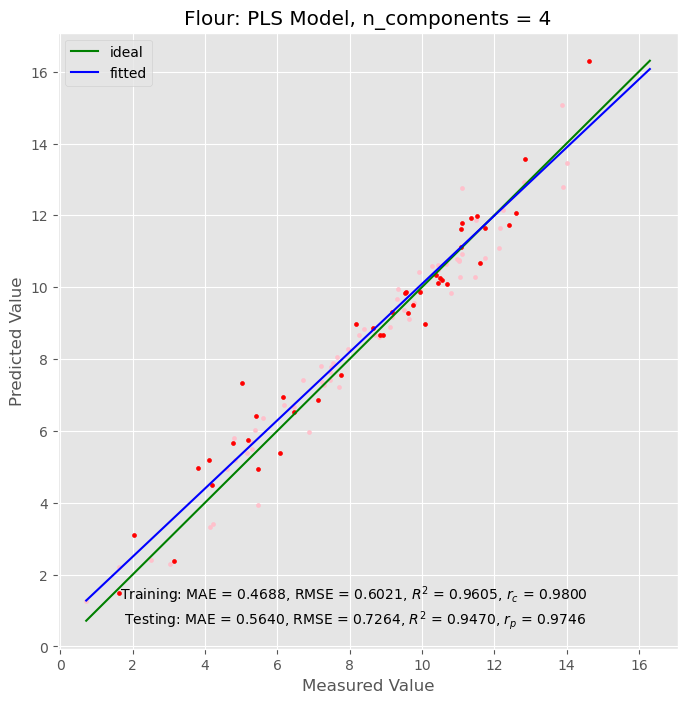

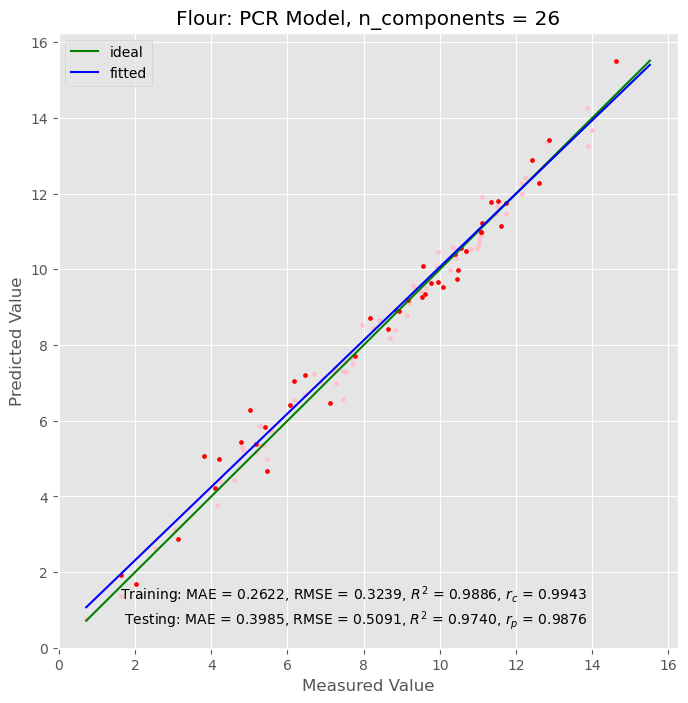

In [27]:
init()

X, Y = get_data('data/面粉含水率.xlsx')

i_train, i_test = custom_train_test_split(X, Y, test_size=43, method='random', random_state=0)

X_train, X_test = X[i_train], X[i_test]
Y_train, Y_test = Y[i_train], Y[i_test]

pls_models = PLS(X_train, X_test, Y_train, Y_test, 4, False, False, True)
pcr_models = PCR(X_train, X_test, Y_train, Y_test, 4, False, False, True)

for model, n_components in pls_models:
    
    Y_train_pred = model.predict(X_train).squeeze()
    Y_test_pred  = model.predict(X_test ).squeeze()
    
    plot_prediction(Y_train, Y_train_pred, Y_test, Y_test_pred, title='Flour: PLS Model, n_components = %d' % n_components, plot=True);

for model, n_components in pcr_models:
    
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    
    Y_train_pred = model.predict(pca.transform(X_train)).squeeze()
    Y_test_pred  = model.predict(pca.transform(X_test )).squeeze()
    
    plot_prediction(Y_train, Y_train_pred, Y_test, Y_test_pred, title='Flour: PCR Model, n_components = %d' % n_components, plot=True);

## A. List of Classes & Functions

In [ ]:
def print_version() -> None

def init() -> None

def curr_date() -> curr_date: str
def curr_time() -> curr_time: str

def  mean_centering(X, axis=None) -> X: np.array(n_samples, n_features)
def   normalization(X, axis=None) -> X: np.array(n_samples, n_features)
def standardization(X, axis=None) -> X: np.array(n_samples, n_features)

def MSC(X, mean_center=True, reference=None) -> X: np.array(n_samples, n_features)

def custom_train_test_split(X, Y, method, test_size, random_state=None) -> i_train: List[int], i_test: List[int]
def max_min_distance_split(distance, train_size) -> i_train: List[int], i_test: List[int]

def plot_prediction(Y_train, Y_train_pred, Y_test, Y_test_pred, title='', plot=True) ->
     mae_train: float,  mae_test: float, \
     mse_train: float,  mse_test: float, \
    rmse_train: float, rmse_test: float, \
      r2_train: float,   r2_test: float, \
       r_train: float,    r_test: float

def plot_loss_and_prediction(history, Y_train, Y_train_pred, Y_test, Y_test_pred, title='', plot=True) ->
     mae_train: float,  mae_test: float, \
     mse_train: float,  mse_test: float, \
    rmse_train: float, rmse_test: float, \
      r2_train: float,   r2_test: float, \
       r_train: float,    r_test: float

class CosineAnnealer

    def __init__(self, start, end, max_steps) -> None
    def step(self) -> learning_rate: float

class ExponentialAnnealer

    def __init__(self, start, end, max_steps) -> None
    def step(self) -> learning_rate: float

class OneCycleScheduler(Callback)

    def __init__(self, lr_min=2**-16, lr_max=2**4, max_steps=2**8, phase_one_pct=0.25, mom_min=0.85, mom_max=0.95) -> None
    
    def on_train_begin(self, logs=None) -> None
    
    def on_train_batch_begin(self, batch, logs=None) -> None
    def on_train_batch_end  (self, batch, logs=None) -> None
    
    def  lr_schedule(self) -> learning_rate: float
    def mom_schedule(self) ->      momentum: float
    
    def get_lr      (self) -> learning_rate: float
    def get_momentum(self) ->      momentum: float
    
    def set_lr      (self,  lr) -> None
    def set_momentum(self, mom) -> None

class LRFinder(Callback)
    
    def __init__(self, lr_min=2**-16, lr_max=2**4, max_steps=2**8, smoothing=1-2**-6, max_loss=4) -> None
    
    def on_train_begin(self, logs=None) -> None
    
    def on_train_batch_end(self, batch, logs=None) -> None
    
    def get_lr(self)     -> learning_rate: float
    def set_lr(self, lr) -> None

class CustomModelCheckpoint(ModelCheckpoint)
    
    def __init__(self, min_epoch=2**8, *args, **kwargs) -> None
    def on_epoch_end(self, epoch, logs=None) -> None

def SPA(X, i_init: int) -> i_select: List[int], n_select: List[float]

def plot_spa_norms(X) -> norms: List[float]

def optimize_pls_components(X, Y, cv) -> mae: np.array(float), mse: np.array(float), rmse: np.array(float), r2: np.array(float), r: np.array(float)
def optimize_pcr_components(X, Y, cv) -> mae: np.array(float), mse: np.array(float), rmse: np.array(float), r2: np.array(float), r: np.array(float)

def PLS(X_train, X_test, Y_train, Y_test, cv, return_coef, return_pred, return_model) -> coefs: List[model.coef_], preds: List[[Y_train_pred, Y_test_pred]], models: List[model]
def PCR(X_train, X_test, Y_train, Y_test, cv, return_coef, return_pred, return_model) -> coefs: List[model.coef_], preds: List[[Y_train_pred, Y_test_pred]], models: List[model]

def make_model_simple      (trial, input_shape=(1899,1), print_model=False, plot_model=False) -> model: model
def make_model_deep_spectra(trial, input_shape=(1899,1), print_model=False, plot_model=False) -> model: model

def predict_model(model, model_name, history, X_calib, X_valid, X_train, X_test, Y_calib, Y_valid, Y_train, Y_test, plot=False, remove=False)
    -> metrics: List[[mae_train, mae_test, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, r_train, r_test]]

def data_preprocessing(trial, X_train, X_test, Y_train, Y_test) ->
    X_calib: np.array(n_samples, n_features), X_valid: np.array(n_samples, n_features),
    X_train: np.array(n_samples, n_features), X_test : np.array(n_samples, n_features),
    Y_calib: np.array(n_samples), Y_valid: np.array(n_samples), Y_train: np.array(n_samples), Y_test: np.array(n_samples)

def objective(trial, model_name, X_train, X_test, Y_train, Y_test) -> 1 - r2_test: float

def custom_logging(study, frozen_trial) -> None

def get_data(filename: str) -> X: np.array(n_samples, n_features), Y: np.array(n_samples)

def get_low_and_high_spectra(X, Y, n=1899) ->
    MI_mean: np.array(n_features), MI_std: np.array(n_features),
    LO_mean: np.array(n_features), LO_std: np.array(n_features),
    HI_mean: np.array(n_features), HI_std: np.array(n_features)

def plot_low_and_high_spectra(X, Y, stats: List[List[float]], n=1899) ->
    LO_results: np.array(n_samples, n_features),
    HI_results: np.array(n_samples, n_features)

def get_feature_map(spectrum: List[float], stats: List[List[float]], log=False, n=1899) -> List[float]